# Análisis de Discretización de Muros
### Autor: Humberto Aldair Rojas Huaroto
### Linkedin: [Humberto Rojas Huaroto](https://www.linkedin.com/in/humberto-rojas-huaroto-63908321a/)
Noviembre 2021

Este cuaderno describe el análisis de convengencia de la discretización de muros en una malla de elementos finitos, tambien se desarrolla un ejemplo de analisis estatico lineal por la norma peruana E030 de un muro acoplado discretizado en elemetos shell.





**1. Instalación de las librerías necesiaras**

In [1]:
import matplotlib
print(matplotlib.__version__)

3.2.2


**2. Importamos las librerías y módulos que se utilizaran**

In [2]:
import numpy as np
from openseespy.opensees import *
import openseespy.postprocessing.ops_vis as opsv
import matplotlib.pyplot as plt

**3. Definimos el sistema de unidades a utilizar**

In [3]:
# Unidades Base
m = 1
kg = 1
s = 1
# Otras Unidades
mm = 0.001*m
cm = 0.01*m
N = kg*m/s**2
kgf = 9.81*N
tonf = 1000*kgf
ton= 1000*kg
Pa = N/m**2
MPa = 10**6*Pa
inch = 2.54*cm
ft = 12*inch
ksi = 6894757.2932*Pa
kip = ksi*inch**2
psi = 6894.76*Pa
# Constantes Físicas
g = 9.81*m/s**2

**4. Definimos las funciones de discretización**

In [4]:
def malla(Tag,N1,N2,N3,N4,Material,ndf,mesh_size):
  mesh('line', (Tag-1)*5+1, 2, N1, N2, 1, ndf, mesh_size)
  mesh('line', (Tag-1)*5+2, 2, N2, N3, 1, ndf, mesh_size)
  mesh('line', (Tag-1)*5+3, 2, N3, N4, 1, ndf, mesh_size)
  mesh('line', (Tag-1)*5+4, 2, N4, N1, 1, ndf, mesh_size)
  eleArgs = ['ShellMITC4',Material]
  mesh("quad", (Tag-1)*5+5, 4, (Tag-1)*5+1, (Tag-1)*5+2, (Tag-1)*5+3, (Tag-1)*5+4, 1, ndf, mesh_size, *eleArgs)

In [5]:
def malla2(Tag,N1,N2,N3,N4,Material,ndf,mesh_sizeX,mesh_sizeZ):
  mesh('line', (Tag-1)*5+1, 2, N1, N2, 1, ndf, mesh_sizeX)
  mesh('line', (Tag-1)*5+2, 2, N2, N3, 1, ndf, mesh_sizeZ)
  mesh('line', (Tag-1)*5+3, 2, N3, N4, 1, ndf, mesh_sizeX)
  mesh('line', (Tag-1)*5+4, 2, N4, N1, 1, ndf, mesh_sizeZ)
  eleArgs = ['ShellMITC4',Material]
  mesh("quad", (Tag-1)*5+5, 4, (Tag-1)*5+1, (Tag-1)*5+2, (Tag-1)*5+3, (Tag-1)*5+4, 1, ndf, mesh_sizeZ/2, *eleArgs)

## IMPORTANCIA DE LA DISCRETIZACIÓN EN MUROS

**5. Definimos el modelo**

In [6]:
wipe()
model('basic', '-ndm', 3, '-ndf', 6)
node(1,0,0,0)
node(2,4,0,0)
node(3,4,0,6)
node(4,0,0,6)

node(5,6,0,0)
node(6,10,0,0)
node(7,10,0,6)
node(8,6,0,6)

node(9,12,0,0)
node(10,16,0,0)
node(11,16,0,6)
node(12,12,0,6)

node(13,18,0,0)
node(14,22,0,0)
node(15,22,0,6)
node(16,18,0,6)
#### fc (kgf/cm2)  ###
fc=280
E=15100*fc**0.5*kgf/cm**2
u=0.2
e=0.25*m
p=2400*kg/m**3
section('ElasticMembranePlateSection' , 1 , E , u , e, p)
element( 'ShellMITC4' , 1 , 1,2,3,4 , 1 )
malla2(1,5,6,7,8,1,6,2,3)
malla2(2,9,10,11,12,1,6,0.5,0.75)
malla2(3,13,14,15,16,1,6,0.125,0.1875)

fixZ(0.0, *[1,1,1,1,1,1], '-tol', 1e-6)
fixY(0.0, *[0,1,0,0,0,0], '-tol', 1e-6)

**6. Ploteamos el modelo**

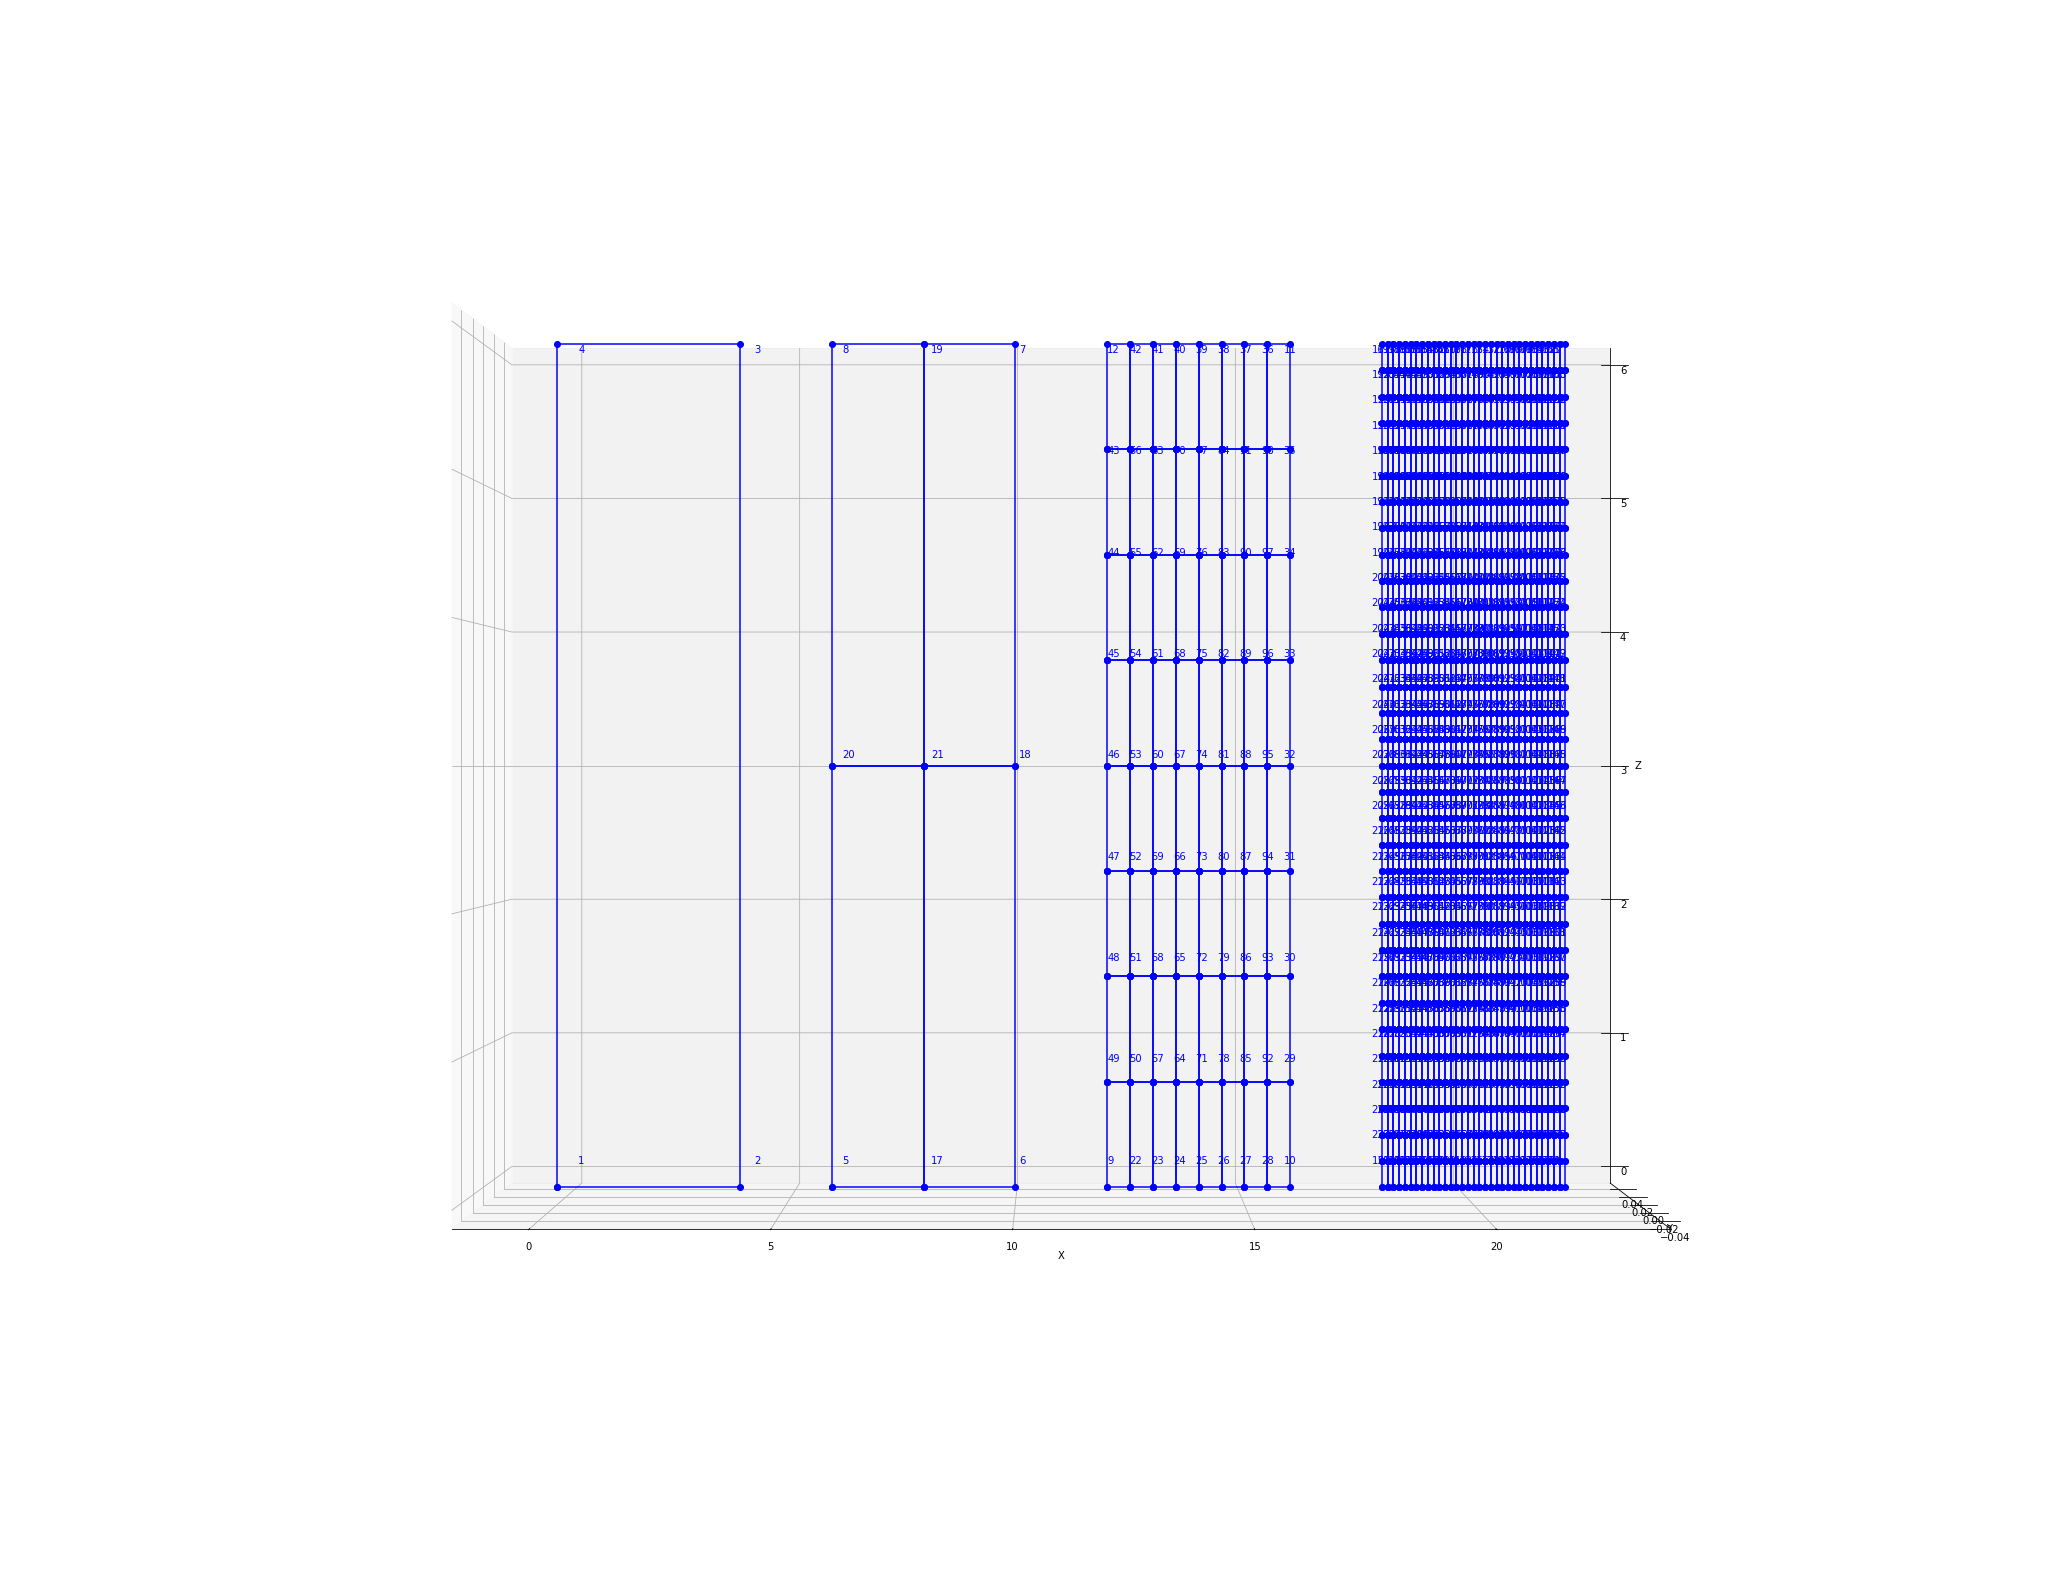

In [7]:
opsv.plot_model(node_labels=1,element_labels=0,fig_wi_he=(80,64),az_el=(-90,0))

**7. Añadimos las cargas en cada muro**

In [8]:
timeSeries('Linear',1)
pattern('Plain',1,1)

P=10*tonf

###  MURO 1  ####
load(4,P/2,0.,0.,0.,0.,0.)
load(3,P/2,0.,0.,0.,0.,0.)

###  MURO 2  ####
load(8,P/3,0.,0.,0.,0.,0.)
load(19,P/3,0.,0.,0.,0.,0.)
load(7,P/3,0.,0.,0.,0.,0.)

###  MURO 3  ####
load(12,P/9,0.,0.,0.,0.,0.)
for i in range(36,43):
  load(i,P/9,0.,0.,0.,0.,0.)
load(11,P/9,0.,0.,0.,0.,0.)

###  MURO 4  ####
load(16,P/33,0.,0.,0.,0.,0.)
for i in range(161,192):
  load(i,P/33,0.,0.,0.,0.,0.)
load(15,P/33,0.,0.,0.,0.,0.)

**8. Configuramos y realizamos el análisis**

In [9]:
wipeAnalysis()
constraints('Plain')
numberer('Plain')
system('FullGeneral')
algorithm('Linear')
integrator('LoadControl',1)
analysis('Static')
analyze(1)

0

**9. Ploteamos la deformación de los muros**

7694.094813287065

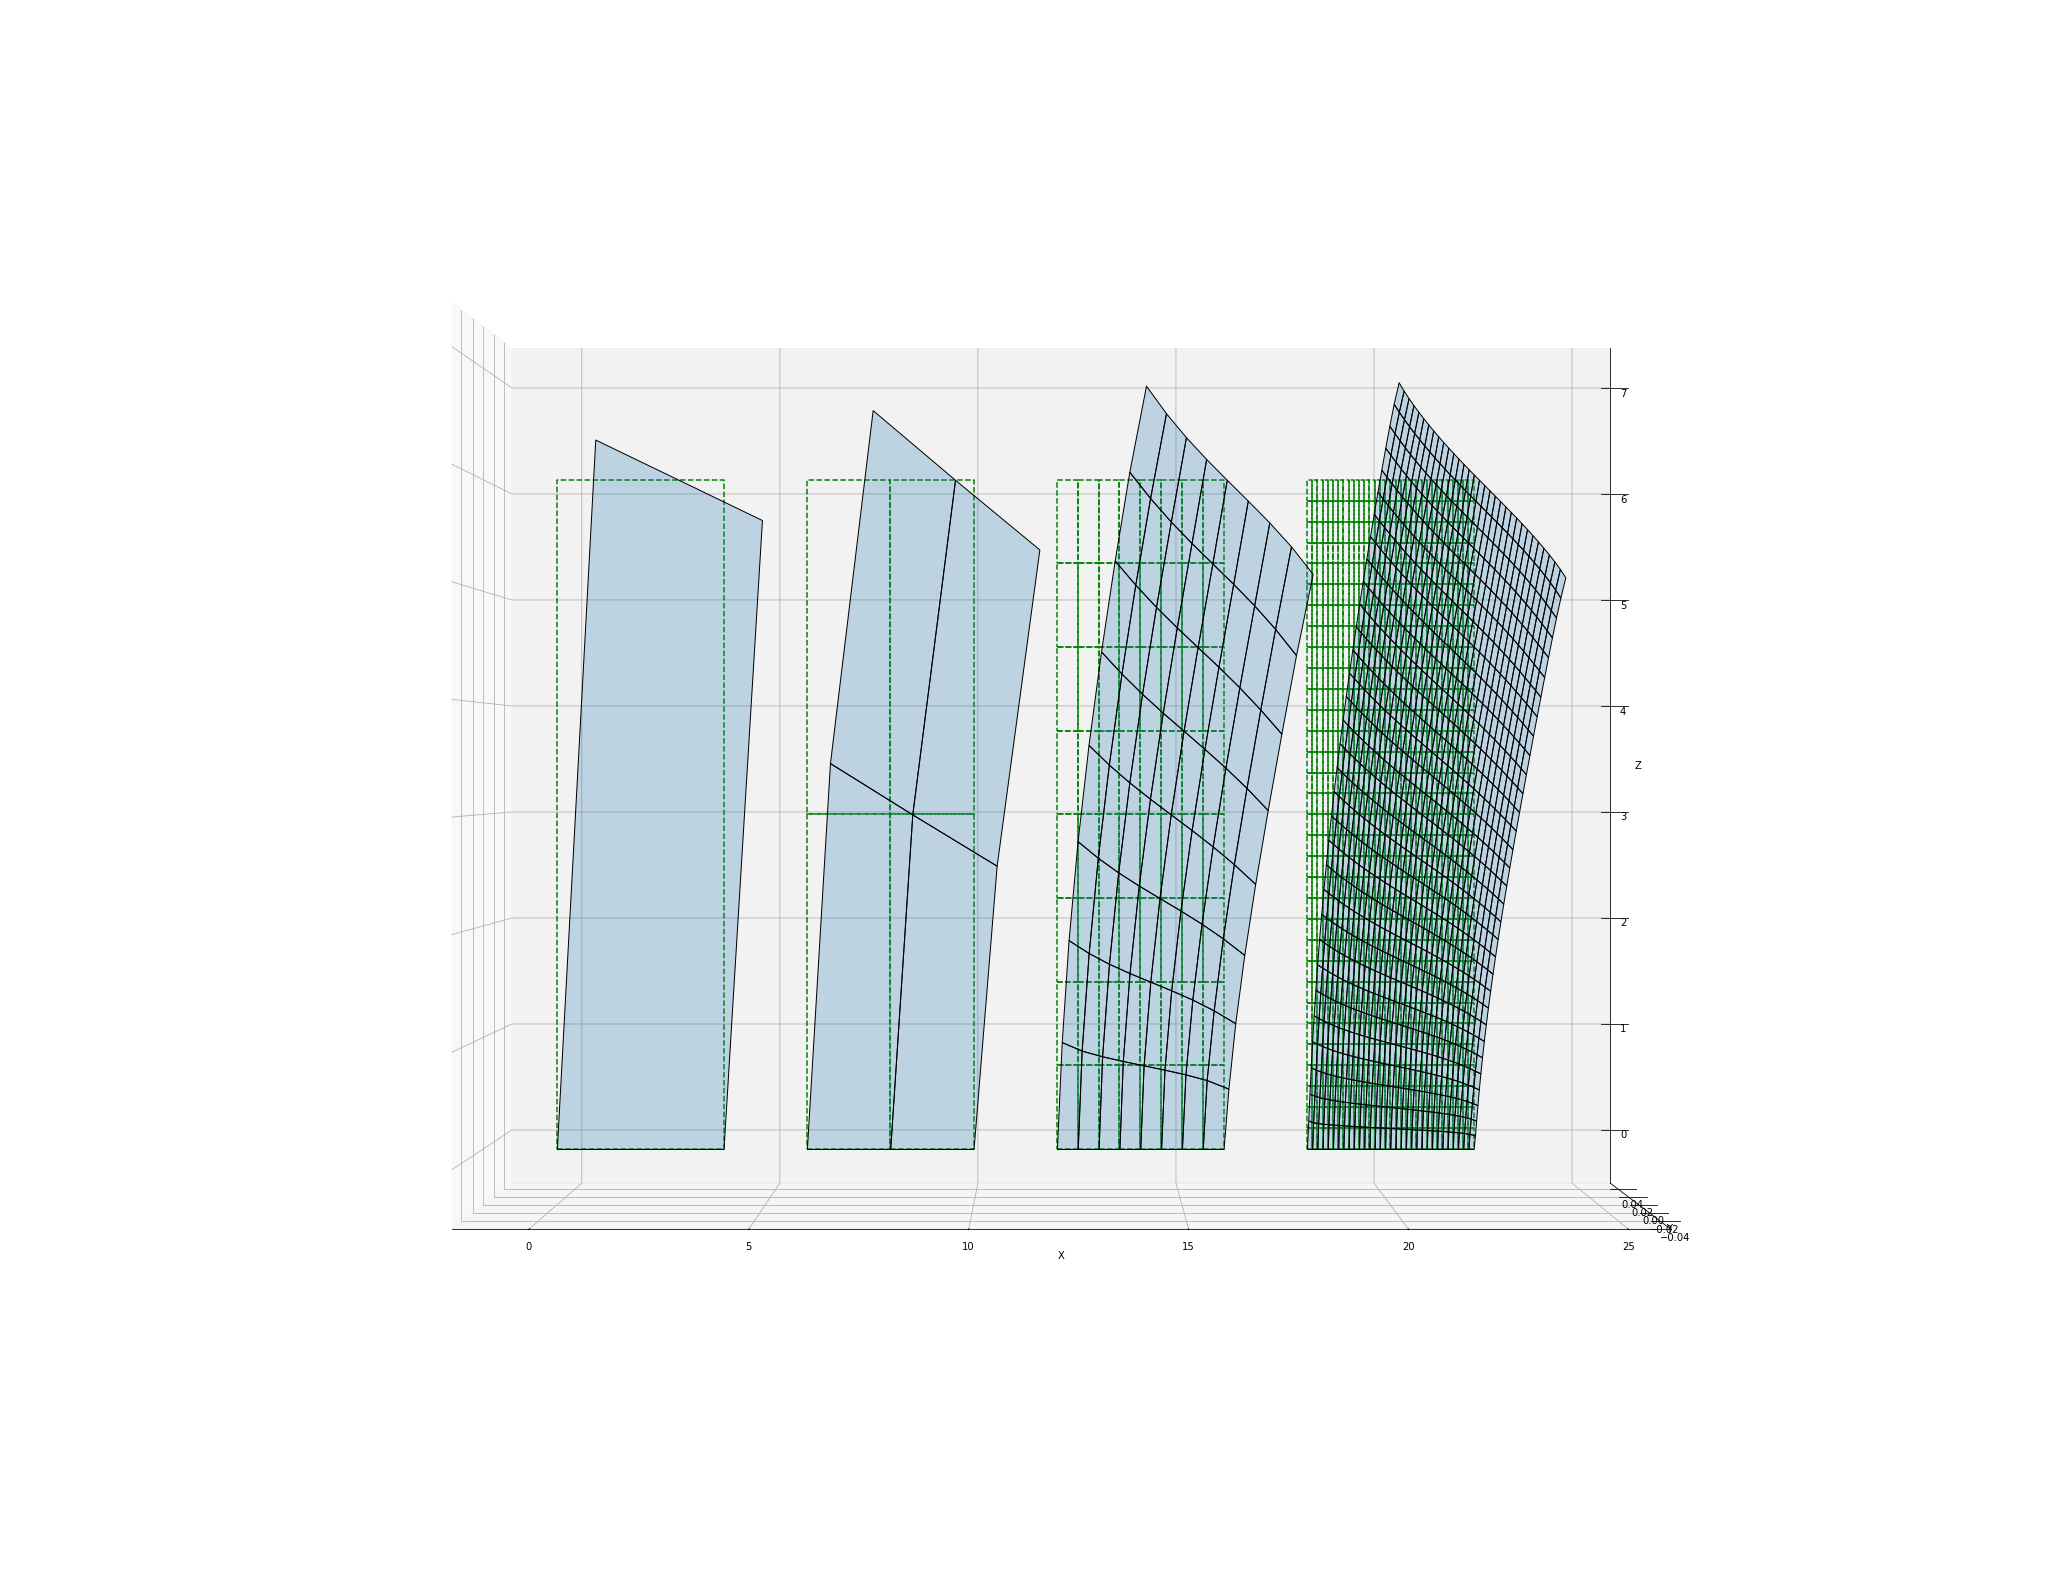

In [10]:
opsv.plot_defo(fig_wi_he=(80., 64.),az_el=(-90,0))

**10. Obtenemos los dezplazamientos de los nodos extremos de cada muro**

In [11]:
disp1 = nodeDisp(3,1)
disp2 = nodeDisp(7,1)
disp3 = nodeDisp(11,1)
disp4 = nodeDisp(15,1)

### Desplazamiento Teórico
L=4
H=6
G=E/(2*(1+u))
I=e*L**3/12
A=5/6*e*L
Δ=P*H**3/(3*E*I)+P*H/(G*A)

**11. Ploteamos el gráfico de la representacion de la convergencia**

(0.0, 0.4)

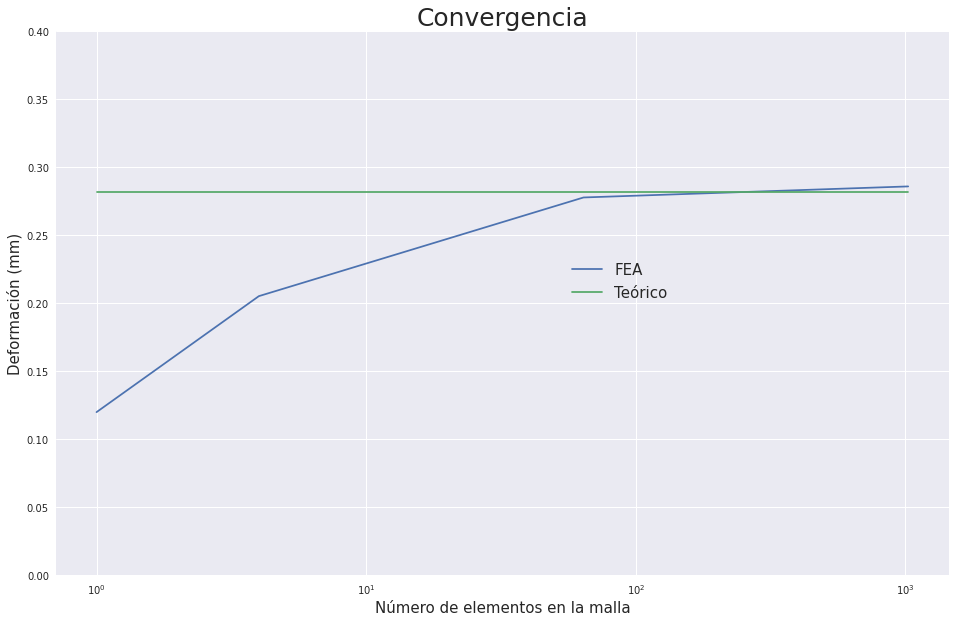

In [12]:
### Numero de elementos
x=[1,4,64,1024]

### Desplazamientos
y_fea=[disp1/mm,disp2/mm,disp3/mm,disp4/mm]
y_teorico=[Δ/mm,Δ/mm,Δ/mm,Δ/mm]

### Ploteo 
fig = plt.figure(figsize=(16, 10))
plt.style.use('seaborn')

plt.plot(x,y_fea,label="FEA")
plt.plot(x,y_teorico,label="Teórico")
plt.xscale("log")
plt.ylabel("Deformación (mm)",fontsize=15)
plt.xlabel("Número de elementos en la malla",fontsize=15)
plt.title("Convergencia",fontsize=25)
plt.legend(bbox_to_anchor=(0.7, 0.6),fontsize=15)
plt.ylim(0,0.4)

## DISCRETIZACIÓN DE MUROS ACOPLADOS

**12. Definimos el modelo de un muro acoplado discretizado en elementos shell**

In [13]:
wipe()
model('basic', '-ndm', 3, '-ndf', 6)
node(1,0,0,0)
node(2,4,0,0)
node(3,4,0,24)
node(4,0,0,24)
node(5,8,0,0)
node(6,12,0,0)
node(7,12,0,24)
node(8,8,0,24)
### fc (kg/cm2)  ####
fc=280
E=15100*fc**(0.5)*kgf/cm**2
u=0.2
e=0.4*m
p=2400*kg/m**3
section('ElasticMembranePlateSection' , 1 , E , u , e, p)
malla(1,1,2,3,4,1,6,0.8)
malla(2,5,6,7,8,1,6,0.8)
malla(3,40,229,8,3,1,6,0.8)
malla(4,35,234,232,37,1,6,0.8)
malla(5,30,239,237,32,1,6,0.8)
malla(6,25,244,242,27,1,6,0.8)
malla(7,20,249,247,22,1,6,0.8)
malla(8,15,254,252,17,1,6,0.8)

fixZ(0.0, *[1,1,1,1,1,1], '-tol', 1e-6)
fixY(0.0, *[0,1,0,0,0,0], '-tol', 1e-6)

**13. Ploteamos el modelo del muro acoplado**

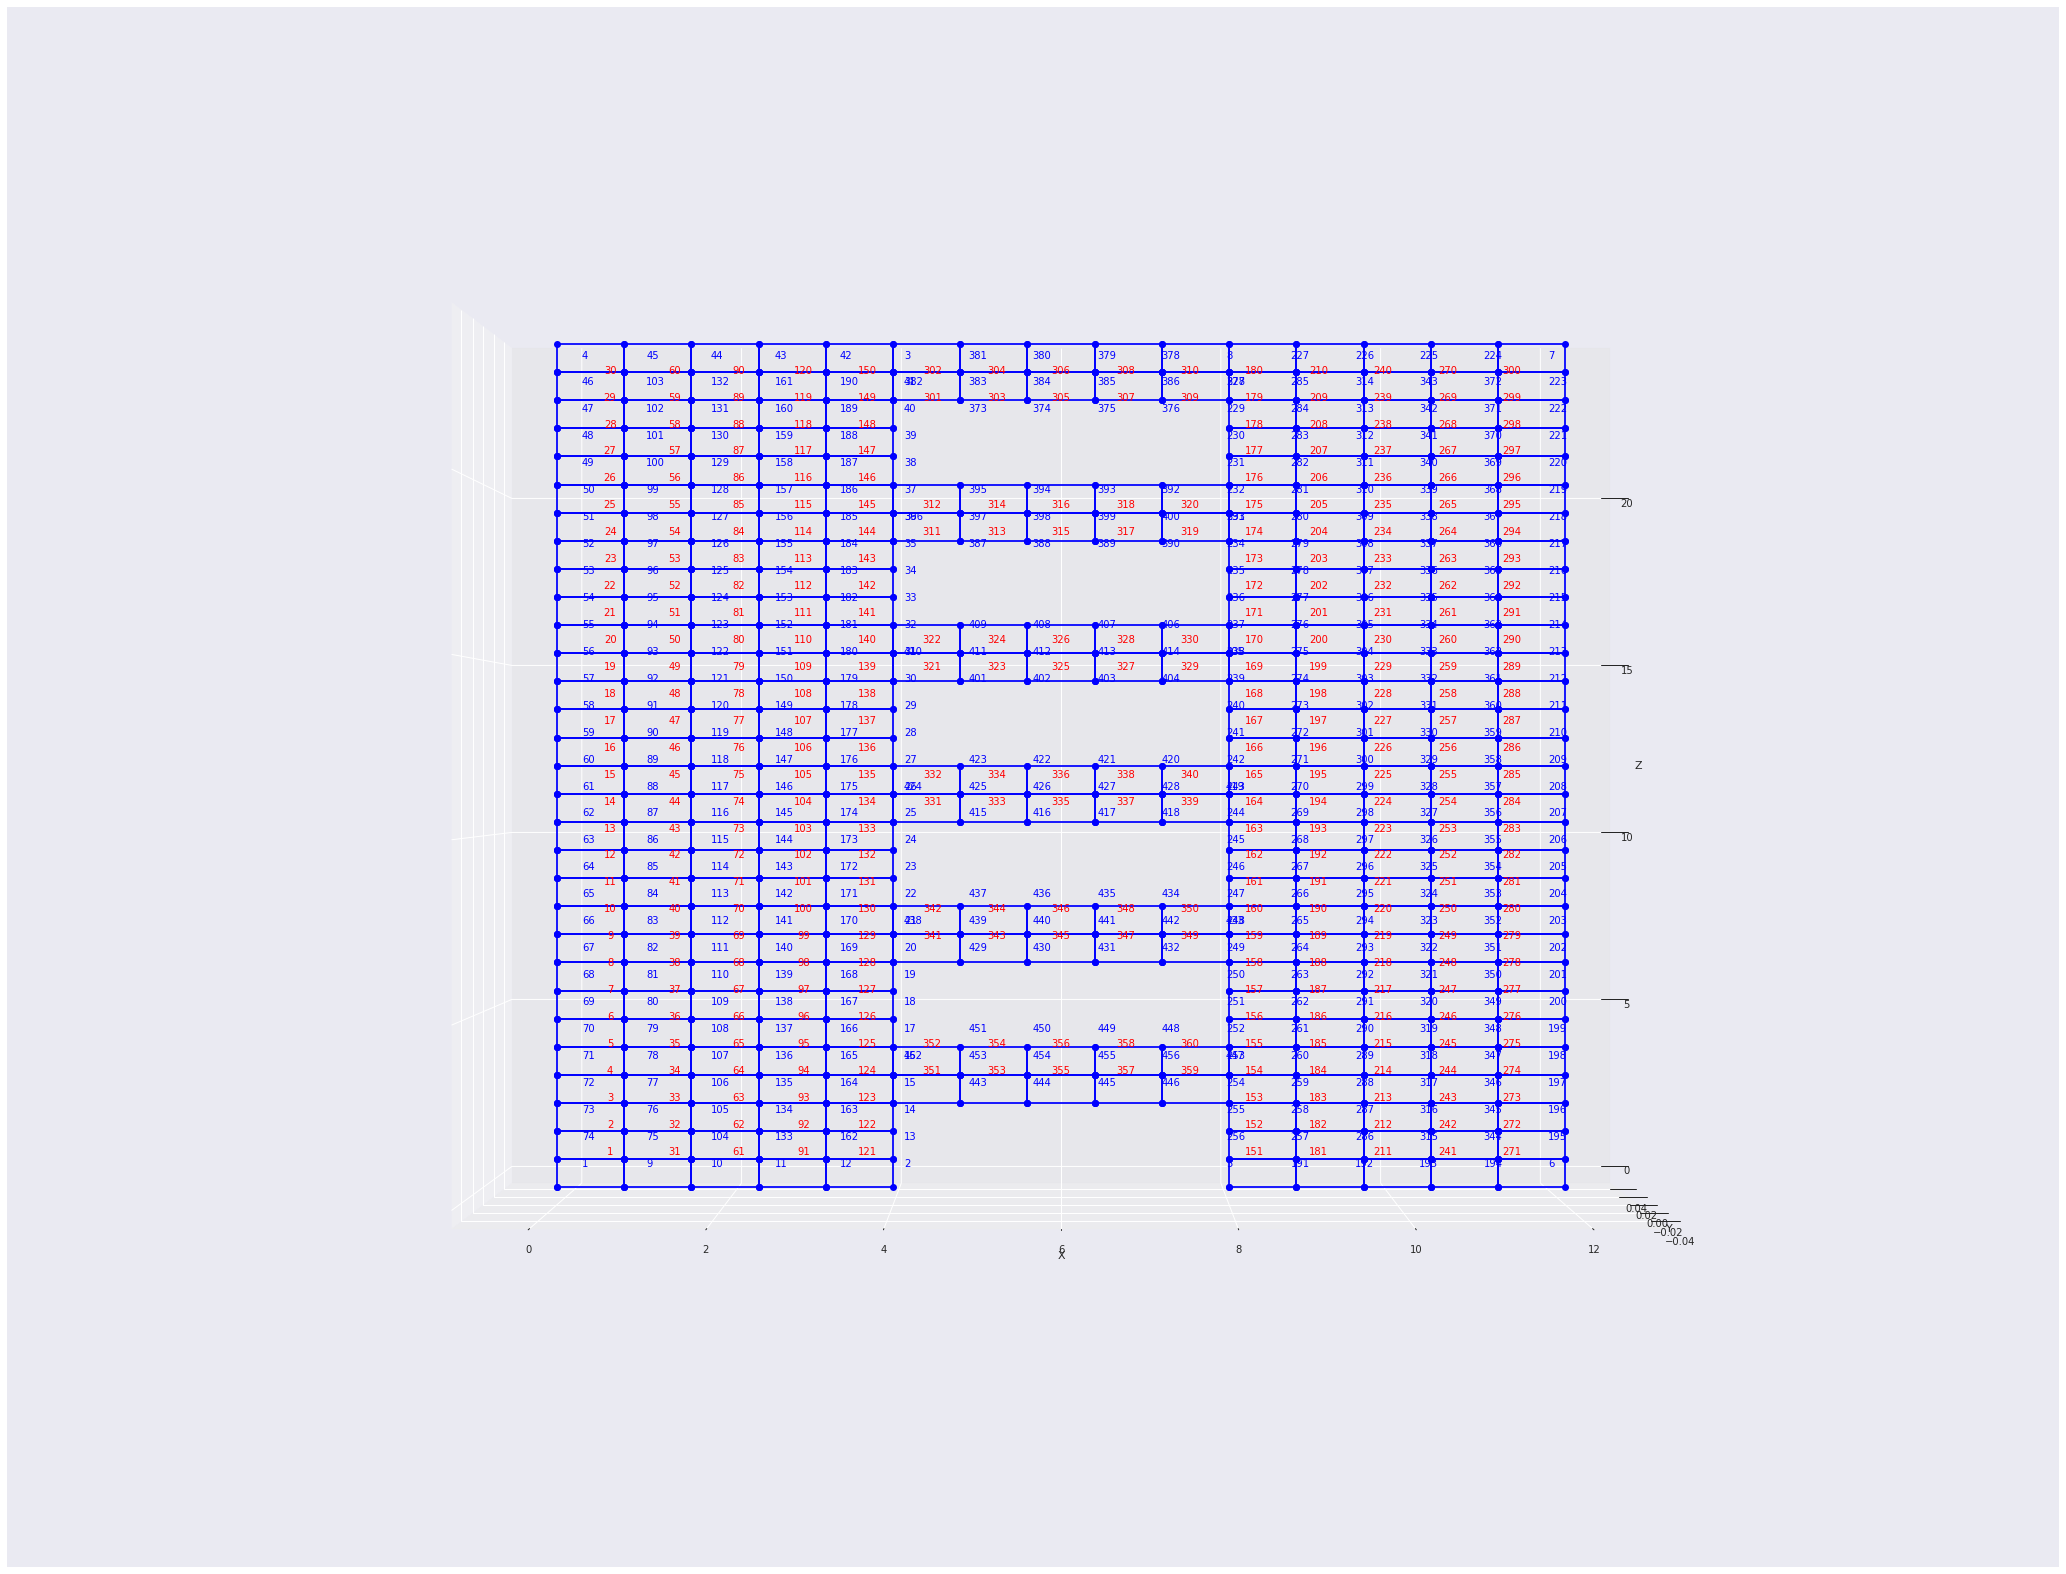

In [14]:
opsv.plot_model(fig_wi_he=(80, 64),az_el=(-90,0))

**14. Añadimos las cargas en el muro acoplado**

In [15]:
timeSeries('Linear',1)
pattern('Plain',1,1)

### Peso de la estructura
P=221.184*tonf

### Parametros de la norma E030
Z, S, Tp, Tl, U, R = 0.45, 1, 0.4, 2.5, 1, 6

### Periodo de la estructura
T=24/60

### Aplicacion de las cargas 

if T<=Tp:
  C=2.5
elif Tp<T<Tl:
  C=2.5*Tp/T
elif Tl<=T:
  C=2.5*Tp*Tl/T
ZUCS=Z*U*C*S
V=ZUCS/R*P
Pi=[P/6,P/6,P/6,P/6,P/6,P/6]
hi=[4,8,12,16,20,24]
if T<0.5:
  k=1
  Suma=sum([Pi[x]*hi[x]**k for x in range(len(Pi))])
  α=[Pi[x]*hi[x]**k/Suma for x in range(len(Pi))]
  load(70,α[0]*V,0.,0.,0.,0.,0.)
  load(65,α[1]*V,0.,0.,0.,0.,0.)
  load(60,α[2]*V,0.,0.,0.,0.,0.)
  load(55,α[3]*V,0.,0.,0.,0.,0.)
  load(50,α[4]*V,0.,0.,0.,0.,0.)
  load(4,α[5]*V,0.,0.,0.,0.,0.)
else:
  k=(0.75+0.5*T)
  Suma=sum([Pi[x]*hi[x]**k for x in range(len(Pi))])
  α=[Pi[x]*hi[x]**k/Suma for x in range(len(Pi))]
  load(70,α[0]*V,0.,0.,0.,0.,0.)
  load(65,α[1]*V,0.,0.,0.,0.,0.)
  load(60,α[2]*V,0.,0.,0.,0.,0.)
  load(55,α[3]*V,0.,0.,0.,0.,0.)
  load(50,α[4]*V,0.,0.,0.,0.,0.)
  load(4,α[5]*V,0.,0.,0.,0.,0.)

**15. Configuramos y realizamos el análisis**

In [16]:
wipeAnalysis()
constraints('Plain')
numberer('Plain')
system('FullGeneral')
algorithm('Linear')
integrator('LoadControl',1)
analysis('Static')
analyze(1)

0

**16. Ploteamos la deformación del muro acoplado**

1290.7207842567689

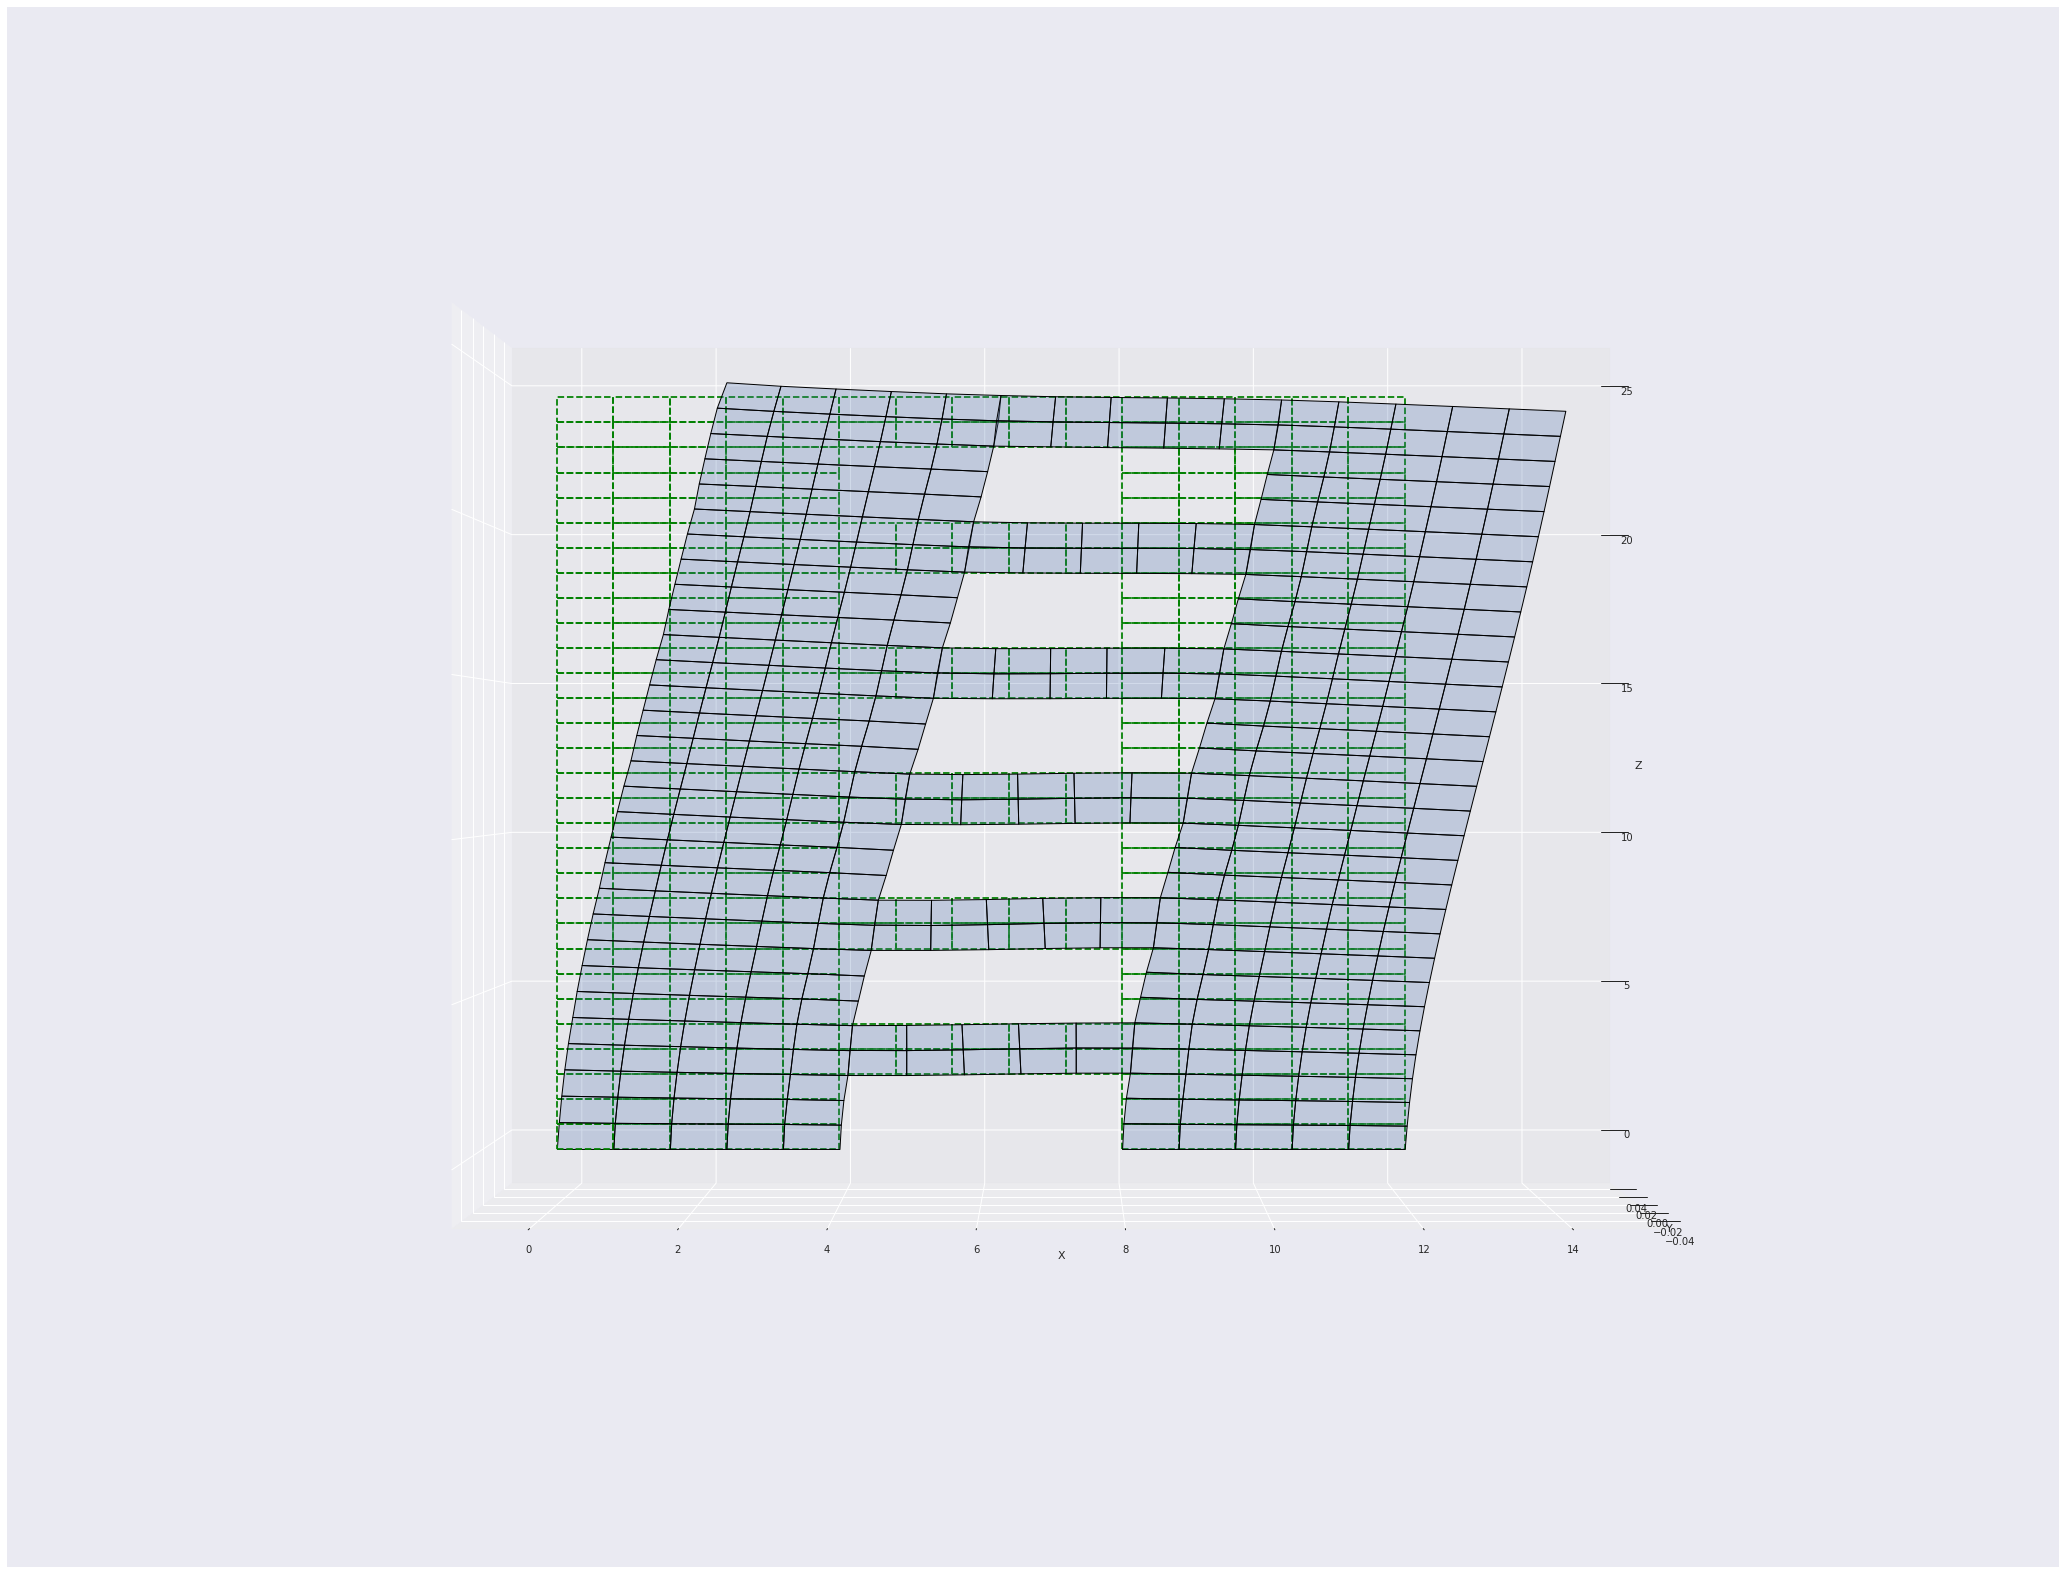

In [17]:
opsv.plot_defo(fig_wi_he=(80., 64.),az_el=(-90,0))

**17. Obtenemos los dezplazamientos de los 4 y 50**

In [18]:
### Hallamos la deriva del ultimo nivel
disp1 = nodeDisp(4,1)
disp2 = nodeDisp(50,1)
deriva_maxima=(disp1-disp2)/4*0.75*R
### Deriva maxima segun la norma E030
deriva_admisible=0.007

### Dezplazamiento del nodo 1 evaluado en Sap2000
disp1_sap2000=0.00194

### Error calculado en %
error=(disp1_sap200-disp1)/disp1_sap200*100

print(deriva_maxima)
print(error)

NameError: name 'disp1_sap200' is not defined